In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
%matplotlib inline

In [3]:
df = pd.read_csv('data/churn-data-set.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [5]:
## missing values
print(f"\n {'Number of null values in every column'.title()} \n {df.isnull().sum()}")

## duplicate values
print(f"\n {'number of duplicate values'.title()} :- {len(df.loc[df.duplicated()])}")

## target value count 
print(f"\n {'count of each value of target column'.title()} \n {df.churn.value_counts()}")


 Number Of Null Values In Every Column 
 state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

 Number Of Duplicate Values :- 0

 Count Of Each Value Of Target Column 
 False    2850
True      483
Name: churn, dtype: int64


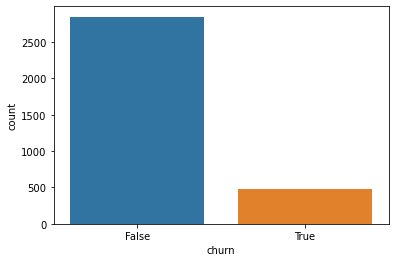

In [6]:
sns.countplot(x='churn', data=df);

In [7]:
#All "Charge" columns are highly correlated with their "minutes" column. So we will drop the charge columns.
#Area Code is a column that has innacurate data, so that will be dropped as well.
df.corr()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
account length,1.000000,-0.012463,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796,0.016541
area code,-0.012463,1.000000,-0.001994,-0.008264,-0.009646,-0.008264,0.003580,-0.011886,0.003607,-0.005825,0.016522,-0.005845,-0.018288,-0.024179,-0.018395,0.027572,0.006174
number vmail messages,-0.004628,-0.001994,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263,-0.089728
total day minutes,0.006216,-0.008264,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423,0.205151
total day calls,0.038470,-0.009646,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942,0.018459
total day charge,0.006214,-0.008264,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427,0.205151
total eve minutes,-0.006757,0.003580,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985,0.092796
total eve calls,0.019260,-0.011886,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423,0.009233
total eve charge,-0.006745,0.003607,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987,0.092786
total night minutes,-0.008955,-0.005825,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288,0.035493


## Data Cleaning

In [8]:
#df1 = df1[[x for x in df1 if not x.endswith('_charge')]]
df.columns = df.columns.str.replace(' ', '_')
df = df.drop([x for x in df.columns if x.endswith('_charge')],axis=1)
df = df.drop(['phone_number', 'area_code'], axis=1)

## Defining X and y as Our Targets and Features

In [9]:
y = df['churn']
X = df.drop(columns='churn', axis=1)

## Train Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30, stratify=y)

## Grabbing All the Categorical Columns

In [11]:
cat_cols = [col for col in X_train.columns if X_train[col].dtypes not in ['float64', 'int64']]
cat_cols

['state', 'international_plan', 'voice_mail_plan']

## Now for the Numerical Columns

In [12]:
num_cols = [col for col in X_train.columns if col not in cat_cols]
num_cols

['account_length',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_eve_minutes',
 'total_eve_calls',
 'total_night_minutes',
 'total_night_calls',
 'total_intl_minutes',
 'total_intl_calls',
 'customer_service_calls']

## Setting Up a Categorical Pipe 

In [13]:
cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

## Now Let's Do the Same for a Numerical Pipe 

In [14]:
num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=0, strategy='mean')),
    ('scaler', StandardScaler())
])

## Creating a Column Transformer 

In [15]:
preprocess = ColumnTransformer(transformers=[
    ('cat_cleaning', cat_pipe, cat_cols),
    ('num_cleaning', num_pipe, num_cols)
])
#preprocess

In [16]:
our_pipe = imbPipeline(steps=[
    ('preprocess', preprocess),
    ('smote', SMOTE()),
    ('log_reg', LogisticRegression())
])

our_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_cleaning',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['state',
                                                   'international_plan',
                                                   'voice_mail_plan']),
                                                 ('num_cleaning',
                                                  Pipeline(steps=[('

# Functions For Fitting Training Data and Printing Scores

In [17]:
def pipe_model_choice(abrv,model):
    model_choice = imbPipeline(steps=[
    ('preprocess', preprocess),
    ('smote', SMOTE()),
    (abrv, model)])
    
    return model_choice

In [18]:
def fit_and_print_scores(model_choice):
    fitted = model_choice.fit(X_train, y_train)
    
    y_trn_pred = fitted.predict(X_train)
    y_tst_pred = fitted.predict(X_test)
    
    print('\t\tThe Train Results')
    print(classification_report(y_train, y_trn_pred))
    print('\n\t\tThe Test Results')
    print(classification_report(y_test, y_tst_pred))
    print('Test Score: ', model_choice.score(X_test, y_test))
    cv_score = cross_val_score(model_choice, X_train, y_train)
    print('Cross Validation Score: ', cv_score.mean())

# BASELINE MODEL

In [19]:
dummy_model = DummyClassifier(strategy="stratified")# We chose 'stratified' because it respects class distributions

fit_and_print_scores(pipe_model_choice('baseline', dummy_model))

		The Train Results
              precision    recall  f1-score   support

       False       0.85      0.49      0.62      2137
        True       0.14      0.51      0.23       362

    accuracy                           0.49      2499
   macro avg       0.50      0.50      0.42      2499
weighted avg       0.75      0.49      0.56      2499


		The Test Results
              precision    recall  f1-score   support

       False       0.85      0.50      0.63       713
        True       0.14      0.47      0.21       121

    accuracy                           0.50       834
   macro avg       0.49      0.49      0.42       834
weighted avg       0.75      0.50      0.57       834

Test Score:  0.46882494004796166
Cross Validation Score:  0.5061987975951904


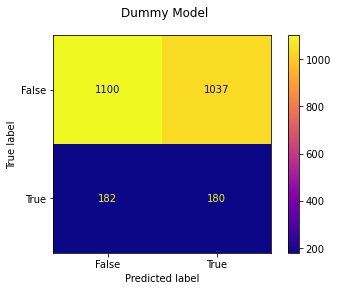

In [20]:
fig, ax = plt.subplots()
fig.suptitle("Dummy Model")
plot_confusion_matrix(dummy_model, X_train, y_train, ax=ax, cmap="plasma");

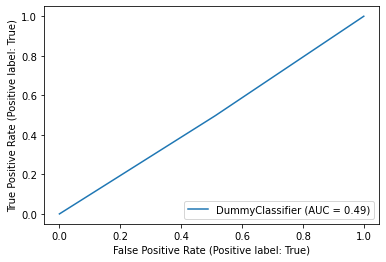

In [21]:
plot_roc_curve(dummy_model,X_train,y_train);

# First Simple Model (Logistic Regression)

In [22]:
fit_and_print_scores(pipe_model_choice('log_reg', LogisticRegression()))

		The Train Results
              precision    recall  f1-score   support

       False       0.95      0.78      0.86      2137
        True       0.37      0.77      0.50       362

    accuracy                           0.78      2499
   macro avg       0.66      0.78      0.68      2499
weighted avg       0.87      0.78      0.81      2499


		The Test Results
              precision    recall  f1-score   support

       False       0.95      0.78      0.86       713
        True       0.38      0.78      0.51       121

    accuracy                           0.78       834
   macro avg       0.67      0.78      0.68       834
weighted avg       0.87      0.78      0.81       834

Test Score:  0.7817745803357314
Cross Validation Score:  0.7691094188376754


# Decision Tree

In [23]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_split=4)

fit_and_print_scores(pipe_model_choice('dt', dt))

		The Train Results
              precision    recall  f1-score   support

       False       0.97      0.91      0.94      2137
        True       0.62      0.86      0.72       362

    accuracy                           0.90      2499
   macro avg       0.80      0.88      0.83      2499
weighted avg       0.92      0.90      0.91      2499


		The Test Results
              precision    recall  f1-score   support

       False       0.98      0.91      0.94       713
        True       0.61      0.87      0.72       121

    accuracy                           0.90       834
   macro avg       0.79      0.89      0.83       834
weighted avg       0.92      0.90      0.91       834

Test Score:  0.9004796163069544
Cross Validation Score:  0.9047655310621241


# =================================================

# Random Forest Classifier

In [24]:
rft = RandomForestClassifier(max_depth=6, 
max_features=11,
min_samples_leaf=5,
min_samples_split=12,
n_estimators=75)

fit_and_print_scores(pipe_model_choice('rf', rft))
#pull out feature importance

		The Train Results
              precision    recall  f1-score   support

       False       0.96      0.91      0.94      2137
        True       0.61      0.80      0.69       362

    accuracy                           0.90      2499
   macro avg       0.79      0.86      0.82      2499
weighted avg       0.91      0.90      0.90      2499


		The Test Results
              precision    recall  f1-score   support

       False       0.97      0.89      0.93       713
        True       0.56      0.82      0.66       121

    accuracy                           0.88       834
   macro avg       0.76      0.85      0.79       834
weighted avg       0.91      0.88      0.89       834

Test Score:  0.8788968824940048
Cross Validation Score:  0.886755110220441


## Making a RandomForest Gridsearch

In [25]:
our_pipe = imbPipeline(steps=[
    ('preprocess', preprocess),
    ('smote', SMOTE()),
    ('rft', RandomForestClassifier(max_depth=6, max_features=11,
                                        min_samples_leaf=4,
                                        min_samples_split=11,
                                        n_estimators=58,
                                  n_jobs=-1,
                                  verbose=3))])

## Setting Parameters

In [26]:
params = {
    'rft__max_depth': [5,6],
    'rft__max_features': [11,12],
    'rft__min_samples_leaf': [4,5],
    'rft__min_samples_split': [10,11],
    'rft__n_estimators': [58, 75],
    
}

## Instantiate GridSearchCV

In [27]:
grid_pipe = GridSearchCV(our_pipe, params, n_jobs = -1, verbose=3, cv=2) 

## Fit Grid_Pipe to X_train, y_train

In [28]:
grid_pipe.fit(X_train, y_train)

Fitting 2 folds for each of 32 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    0.1s 

[Parallel(n_jobs=8)]: Done  58 out of  58 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  58 out of  58 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  58 out of  58 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    0.1s remainin

[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 1 of 58building tree 2 of 58
building tree 3 of 58
building tree 4 of 58

building tree 5 of 58building tree 6 of 58
building tree 7 of 58

building tree 8 of 58
building tree 9 of 58
building tree 10 of 58building tree 11 of 58
building tree 12 of 58building tree 13 of 58


building tree 14 of 58building tree 15 of 58
building tree 16 of 58

building tree 17 of 58
building tree 18 of 58
building tree 19 of 58
building tree 20 of 58building tree 21 of 58
building tree 22 of 58building tree 23 of 58


building tree 24 of 58
building tree 25 of 58
building tree 26 of 58
building tree 27 of 58building tree 28 of 58building tree 29 of 58


building tree 30 of 58building tree 31 of 58

building tree 32 of 58
building tree 33 of 58
building tree 34 of 58
building tree 35 of 58
building tree 36 of 58
building tree 37 of 58building tree 38 of 58
building tree 39 of 58

building tree 40 of 58
building tree 41 of 58
building tree 42 of 58
building tree 43 of 58
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    0.1s finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_cleaning',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['state',
                                                     

## Gives the Max Result. This is Our Model

In [29]:
grid_pipe.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_cleaning',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['state',
                                                   'international_plan',
                                                   'voice_mail_plan']),
                                                 ('num_cleaning',
                                                  Pipeline(steps=[('

In [30]:
grid_pipe = grid_pipe.best_estimator_

#  Machine Modeling on a Tuesday Afternoon 

## Confusion Matrix for Gridsearch Random Forest

In [31]:
y_predict = grid_pipe.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  58 out of  58 | elapsed:    0.0s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  58 out of  58 | elapsed:    0.0s finished


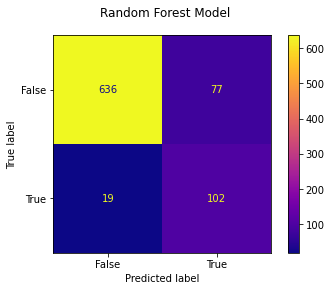

In [32]:
fig, ax = plt.subplots()
fig.suptitle("Random Forest Model")
plot_confusion_matrix(grid_pipe, X_test, y_test, ax=ax, cmap="plasma");

# ==============================================================

# The Multi-Layered Model

In [33]:
layer_one_estimators = [
     
    ('rf_1', RandomForestClassifier(n_estimators=58, 
                                     random_state=42,
                                    min_samples_leaf=4,
                                    min_samples_split=13,
                                    max_features=11)),
    
    ('knn_1', KNeighborsClassifier(n_neighbors=13)),
    
    ('Ada_1', AdaBoostClassifier(n_estimators=50, learning_rate=1,random_state=42)),
]



layer_two_estimators = [
    
    ('dt_2', DecisionTreeClassifier(random_state=42,
                                           criterion = 'entropy',
                                           max_depth = 25,
                                           min_samples_split = 2,
                                           min_samples_leaf = 2,
                                           max_leaf_nodes = 15)),
     
    ('rf_2', RandomForestClassifier(n_estimators=58, 
                                     random_state=42,
                                    min_samples_leaf=4,
                                    min_samples_split=11,
                                    max_features=2))
]



layer_two = StackingClassifier(estimators=layer_two_estimators, final_estimator=LogisticRegression(C=0.9,
                                                                                                   penalty='l2',
                                                                                                  random_state=42,
                                                                                                  solver='saga',
                                                                                                  max_iter=10000,
                                                                                                   warm_start=True,))
     
# Creating the multi-layered model
layers = StackingClassifier(estimators=layer_one_estimators, final_estimator=layer_two)

## Getting the Scores and Fitting 

In [34]:
fit_and_print_scores(pipe_model_choice('layers', layers))

		The Train Results
              precision    recall  f1-score   support

       False       0.98      0.97      0.98      2137
        True       0.83      0.90      0.87       362

    accuracy                           0.96      2499
   macro avg       0.91      0.94      0.92      2499
weighted avg       0.96      0.96      0.96      2499


		The Test Results
              precision    recall  f1-score   support

       False       0.98      0.93      0.95       713
        True       0.69      0.87      0.77       121

    accuracy                           0.92       834
   macro avg       0.83      0.90      0.86       834
weighted avg       0.93      0.92      0.93       834

Test Score:  0.9232613908872902
Cross Validation Score:  0.9191687374749499


In [35]:
our_layers_pipe = imbPipeline(steps=[
    ('preprocess', preprocess),
    ('smote', SMOTE()),
    ('layers', layers)
    
])

# Multi-layered Confusion Matrices

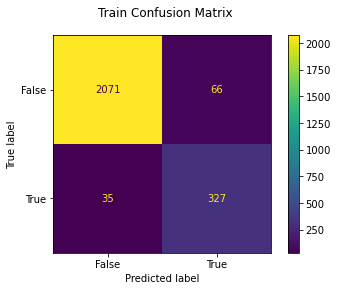

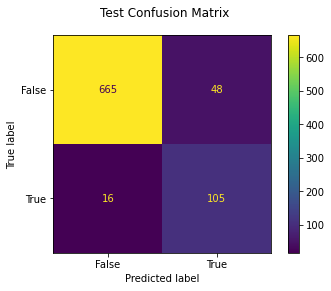

In [44]:
fig, ax = plt.subplots()
fig.suptitle('Train Confusion Matrix')
plot_confusion_matrix(our_layers_pipe, X_train, y_train, ax=ax, normalize=None)

fig, ax = plt.subplots()
fig.suptitle('Test Confusion Matrix')
plot_confusion_matrix(our_layers_pipe, X_test, y_test, ax=ax, normalize=None);

# Visualizations

In [45]:
#Getting the features that impact Churn the most
cat_ohe_cols = grid_pipe.named_steps['preprocess'].named_transformers_['cat_cleaning'].named_steps['ohe'].get_feature_names(cat_cols).tolist()
feat_cols = cat_ohe_cols + num_cols
X_train_tf = pd.DataFrame(grid_pipe.named_steps['preprocess'].fit_transform(X_train), columns=feat_cols)
important_feats = pd.Series(grid_pipe.named_steps['rft'].feature_importances_, index=feat_cols)
top_feats = important_feats.sort_values(ascending=False).head(10)

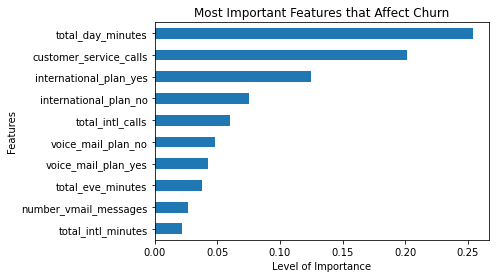

In [46]:
plt.Figure(figsize=(5, 5))
top_feats.sort_values().plot(kind='barh')
plt.xlabel('Level of Importance')
plt.ylabel('Features')
plt.title('Most Important Features that Affect Churn');

In [55]:
metrics = pd.DataFrame(columns=['Model', 'Recall', 'Churn'])
metrics.loc[len(metrics.index)] = ['Simple', .78, 0]
metrics.loc[len(metrics.index)] = ['Simple', .81, 1]
metrics.loc[len(metrics.index)] = ['Complex', .94, 0] 
metrics.loc[len(metrics.index)] = ['Complex', .87, 1] 

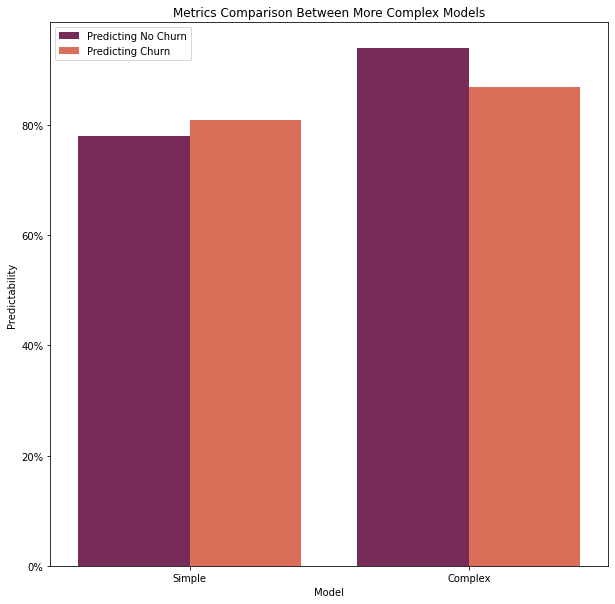

In [56]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x = 'Model', y = 'Recall',
            hue= 'Churn', ax=ax, data=metrics, palette='rocket', ci=None)
plt.title("Metrics Comparison Between More Complex Models")
plt.legend(['Predicting No Churn', 'Predicting Churn']);
plt.ylabel("Predictability");
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
#if you already have ticks in the 0 to 1 range. Otherwise see their answer

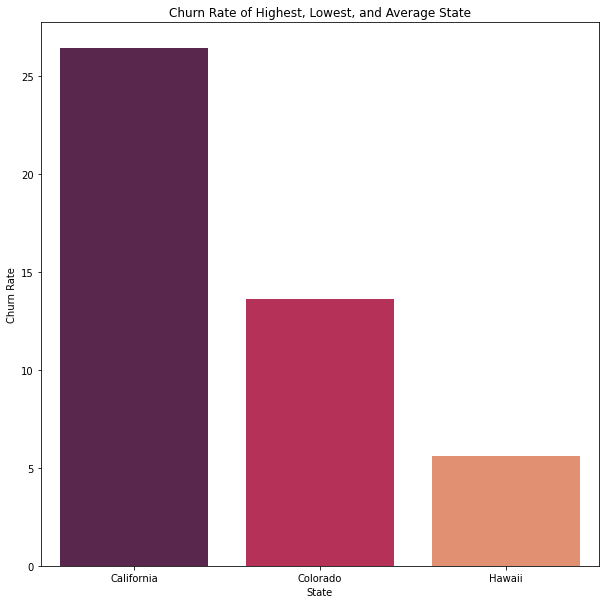

In [49]:
state_totals = df.groupby('state').count()['churn']
state_trues = df.groupby('state')['churn'].sum().sort_values()
state_totals = df.groupby('state').count()['churn']

churn_perc = state_trues / state_totals
churn_perc.sort_values()
areas = pd.DataFrame(columns=['State', 'Churn Rate'])
areas.loc[len(areas.index)] = ['California', 26.4]
areas.loc[len(areas.index)] = ['Colorado', 13.6] 
areas.loc[len(areas.index)] = ['Hawaii', 5.6] 
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x = 'State', y = 'Churn Rate', ax=ax, data=areas, palette='rocket', ci=None)
plt.title("Churn Rate of Highest, Lowest, and Average State");

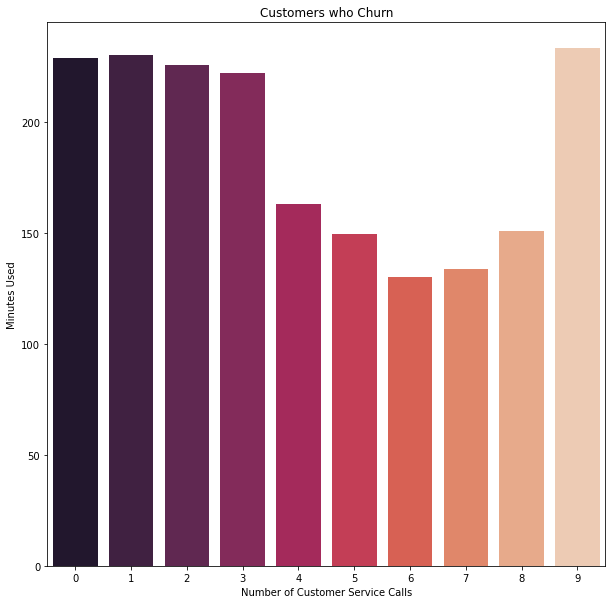

In [51]:
df_churn = df.loc[df['churn'] == 1]
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x = 'customer_service_calls', y = 'total_day_minutes'
            , ax=ax, data=df_churn, palette='rocket', ci=None)
plt.title("Customers who Churn")
plt.xlabel("Number of Customer Service Calls")
plt.ylabel("Minutes Used");

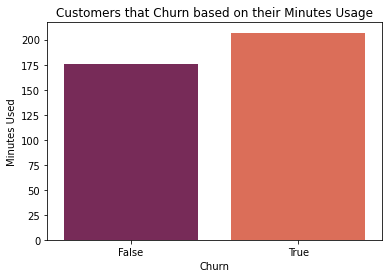

In [57]:
ax = sns.barplot(x="churn", y="total_day_minutes", data=df, ci=False, palette='rocket')
plt.title('Customers that Churn based on their Minutes Usage')
plt.xlabel('Churn')
plt.ylabel('Minutes Used');